In [127]:
!pip install keras_tuner

In [128]:
import pandas as pd
import os

df = pd.read_csv(
    "yahoo_stock.csv",
    sep=',',
    na_values=['-1'], index_col=False)

print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

Starting file:
         Date         High          Low         Open        Close  \
0  2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088   
1  2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893   
2  2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117   
3  2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117   
4  2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   
5  2015-11-28  2093.290039  2084.129883  2088.820068  2090.110107   
6  2015-11-29  2093.290039  2084.129883  2088.820068  2090.110107   
7  2015-11-30  2093.810059  2080.409912  2090.949951  2080.409912   
8  2015-12-01  2103.370117  2082.929932  2082.929932  2102.629883   
9  2015-12-02  2104.270020  2077.110107  2101.709961  2079.510010   

         Volume    Adj Close  
0  3.587980e+09  2086.590088  
1  3.884930e+09  2089.139893  
2  2.852940e+09  2088.870117  
3  2.852940e+09  2088.870117  
4  1.466840e+09  2090.110107  
5  1.466840e+09  2090.110107  
6  1.466

In [129]:

from sklearn.model_selection import train_test_split

# Assuming 'data' is your dataset and 'labels' are the corresponding labels
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Now X_train and y_train contain 70% of the data for training, and X_test and y_test contain 30% for testing

spots_train = df_train['Close'].tolist()
spots_test = df_test['Close'].tolist()

print("Training set has {} observations.".format(len(spots_train)))
print("Test set has {} observations.".format(len(spots_test)))

Training set has 1277 observations.
Test set has 548 observations.


In [130]:
import numpy as np

def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x),np.array(y)


SEQUENCE_SIZE = 10
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (1267, 10, 1)
Shape of test set: (538, 10, 1)


In [131]:
print(x_train.shape)

(1267, 10, 1)


In [132]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

The following function is provided to build the model, including the attention layer.

In [142]:
def build_model(hp):
    # hyper paramters here
    num_heads = hp.Int('num_heads', min_value=2, max_value=6, step=1)
    ff_dim = hp.Int('ff_dim', min_value=4, max_value=20, step=4)
    num_transformer_blocks = hp.Int('num_transformer_blocks', min_value=2, max_value=5, step=1)

    # input_shape,
    head_size = 256
    mlp_units=[128]
    mlp_dropout=0.4
    dropout=0.25

    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    transformer_model = keras.Model(inputs, outputs)
    transformer_model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4))
    return transformer_model

In [143]:
input_shape = x_train.shape[1:]
#Hype tuning

import keras_tuner as kt

tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')
import tensorflow as tf
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=4,
                                      verbose=1,
                                      restore_best_weights='True',
                                      min_delta = 0.1
                                     )


Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [144]:
tuner.search(x_train, y_train,
             epochs=50,
             validation_data=(x_train, y_train),
             validation_split=0.2,
             callbacks=[ES]
            )

In [145]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('num_heads'))
print(best_hps.get('ff_dim'))
print(best_hps.get('num_transformer_blocks'))


6
4
2


In [146]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=50,
)

Epoch 1/50
32/32 [==============================] - 6s 21ms/step - loss: 4293414.5000 - val_loss: 2678130.2500
Epoch 2/50
32/32 [==============================] - 0s 11ms/step - loss: 2398730.5000 - val_loss: 1133258.0000
Epoch 3/50
32/32 [==============================] - 0s 12ms/step - loss: 1414226.6250 - val_loss: 478335.4375
Epoch 4/50
32/32 [==============================] - 0s 12ms/step - loss: 1027590.1875 - val_loss: 256042.2031
Epoch 5/50
32/32 [==============================] - 0s 13ms/step - loss: 942935.1250 - val_loss: 211707.2500
Epoch 6/50
32/32 [==============================] - 0s 13ms/step - loss: 883471.0625 - val_loss: 202976.7812
Epoch 7/50
32/32 [==============================] - 0s 11ms/step - loss: 867048.6250 - val_loss: 199694.2812
Epoch 8/50
32/32 [==============================] - 0s 12ms/step - loss: 831649.8125 - val_loss: 199458.8125
Epoch 9/50
32/32 [==============================] - 0s 12ms/step - loss: 864017.8125 - val_loss: 198896.8750
Epoch 10/50
3

In [148]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('num_heads'))
print(best_hps.get('ff_dim'))
print(best_hps.get('num_transformer_blocks'))


6
4
2


In [149]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=50,
)

Epoch 1/50
32/32 [==============================] - 6s 20ms/step - loss: 7865862.5000 - val_loss: 5060729.5000
Epoch 2/50
32/32 [==============================] - 0s 12ms/step - loss: 4890655.0000 - val_loss: 2658446.5000
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 3064850.2500 - val_loss: 1244328.8750
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 1955493.2500 - val_loss: 516190.6875
Epoch 5/50
32/32 [==============================] - 0s 12ms/step - loss: 1517870.2500 - val_loss: 268134.6250
Epoch 6/50
32/32 [==============================] - 0s 12ms/step - loss: 1337691.0000 - val_loss: 195476.5938
Epoch 7/50
32/32 [==============================] - 0s 14ms/step - loss: 1376051.2500 - val_loss: 176010.7656
Epoch 8/50
32/32 [==============================] - 0s 13ms/step - loss: 1311708.8750 - val_loss: 172892.8750
Epoch 9/50
32/32 [==============================] - 0s 12ms/step - loss: 1319431.1250 - val_loss: 174902.0312
Epoch 1

In [150]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_absolute_percentage_error(pred,y_test))
print("Score (MAPE): {}".format(score))

17/17 [==============================] - 0s 4ms/step
Score (MAPE): 0.3802360887962956


dict_keys(['loss', 'val_loss'])


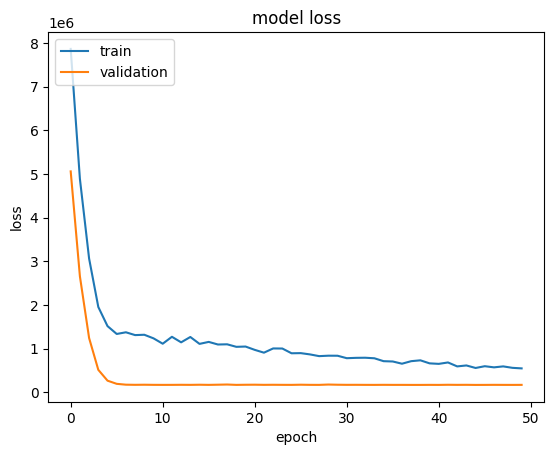

In [151]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [152]:
y_test = y_test.reshape(-1)
pred = pred.reshape(-1)
result = y_test - pred


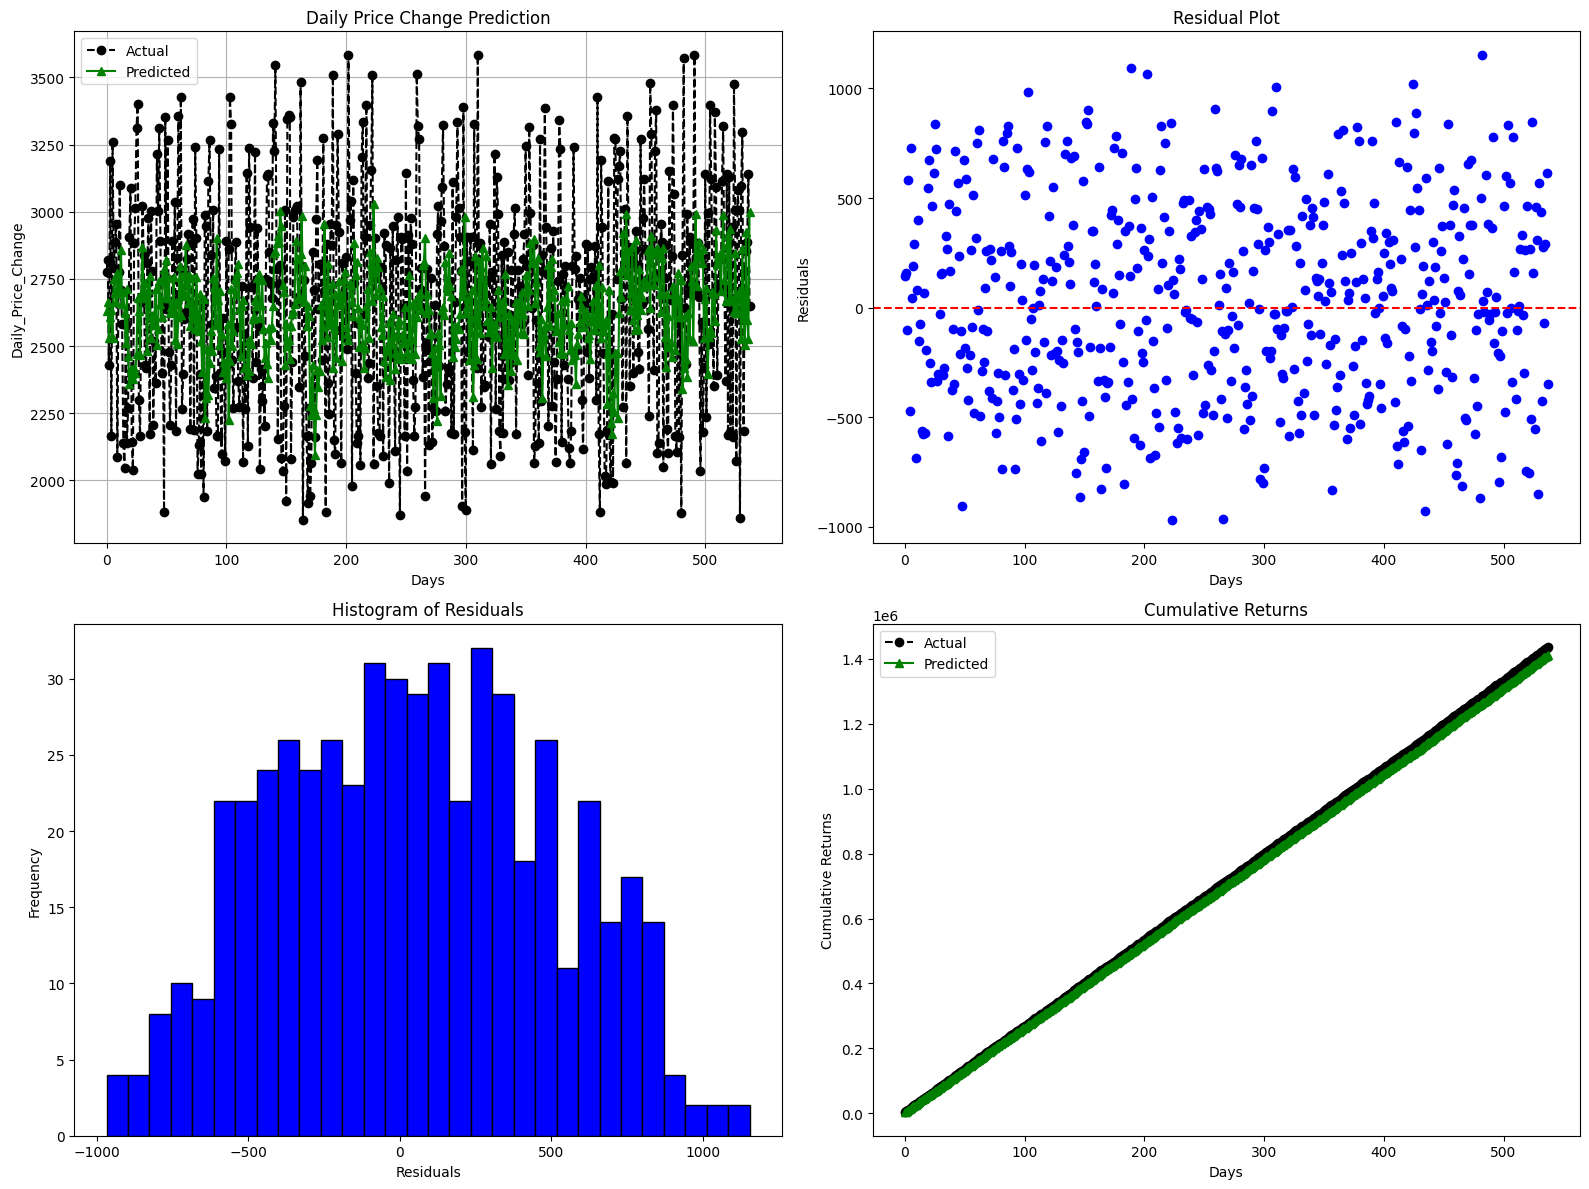

In [153]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming y_test and pred are NumPy arrays or lists
rmse = np.sqrt(mean_squared_error(y_test, pred))

residuals = y_test - pred

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Actual vs. Predicted
axs[0, 0].plot(y_test, color='black', label='Actual', linestyle='--', marker='o')
axs[0, 0].plot(pred, color='green', label='Predicted', linestyle='-', marker='^')
axs[0, 0].set_title('Daily Price Change Prediction')
axs[0, 0].set_ylabel('Daily_Price_Change')
axs[0, 0].set_xlabel('Days')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Residual Plot
axs[0, 1].plot(residuals, color='blue', linestyle='', marker='o')
axs[0, 1].axhline(y=0, color='red', linestyle='--')
axs[0, 1].set_title('Residual Plot')
axs[0, 1].set_xlabel('Days')
axs[0, 1].set_ylabel('Residuals')

# Plot 3: Histogram of Residuals
axs[1, 0].hist(residuals, bins=30, color='blue', edgecolor='black')
axs[1, 0].set_title('Histogram of Residuals')
axs[1, 0].set_xlabel('Residuals')
axs[1, 0].set_ylabel('Frequency')

# Plot 4: Cumulative Returns
cumulative_returns_actual = np.cumsum(y_test)
cumulative_returns_pred = np.cumsum(pred)

axs[1, 1].plot(cumulative_returns_actual, label='Actual', color='black', linestyle='--', marker='o')
axs[1, 1].plot(cumulative_returns_pred, label='Predicted', color='green', linestyle='-', marker='^')
axs[1, 1].set_title('Cumulative Returns')
axs[1, 1].set_xlabel('Days')
axs[1, 1].set_ylabel('Cumulative Returns')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()